In [ ]:
require(tidyverse)
require(magrittr)
require(ggraph)
require(igraph)
require(phytools)
require(RColorBrewer)

In [ ]:
sampleid <- 'EB_D10a'

In [ ]:
### load allele table
allele_table_greedy <- read.csv("/path/to/allele_table.csv", row.names = 1)

In [ ]:
### load newick file for each clone
newick_files = list.files(path = "path/to/*.newick", pattern = "*.newick", full.names = TRUE)
newick_cloneIDs = as.numeric(strsplit(newick_files, "/") %>% map_chr(4)
names(newick_files) = newick_cloneIDs

In [ ]:
### cell type annotation
sc_anno <- read.csv("path/to/annotation.csv")

In [ ]:
vertices_df <- sc_anno %>%
  filter(sample == "D10a") %>%
  select(cellBC, cell_type) %>%
  mutate(cellBC = strsplit(cellBC,"_") %>% purrr::map(~paste(.x[1:2], collapse = "_")) %>% unlist())

vertices_df  <- allele_table_greedy %>%
  select(cellBC, lineageGrp) %>%
  distinct() %>%
  inner_join(.,vertices_df)

vertices_df %<>% rename(c('V1' = 'lineageGrp', 'V2' = 'cellBC', 'sample' = 'cell_type')) %>%
  select(V1,V2,sample)

In [ ]:
### get all clones 
all_clones_list = allele_table_greedy %>% distinct(lineageGrp) %>% filter(!is.na(lineageGrp)) %>% deframe()

In [ ]:
pos = 1

edge_lists = list()

for (clone in all_clones_list) {
  
  print(clone)
  if (clone %in% newick_cloneIDs) {
    
    vertices_df_sub <- vertices_df[vertices_df$V1 == clone,] %>% 
      select(-V1) %>% 
      mutate(V2 = paste('Clone', as.character(clone), '-', V2, sep = ''))
      
    tree = read.tree(newick_files[which(names(newick_files) == clone)])
    temp_graph = as.igraph(tree)
    
    elist_df = as.data.frame(as_edgelist(temp_graph)) %>%
      # mutate(sample = NA) %>%
      mutate(V1 = paste('Clone', as.character(clone), '-', V1, sep = '')) %>%
      mutate(V2 = paste('Clone', as.character(clone), '-', V2, sep = '')) %>%
      left_join(vertices_df_sub) %>%
      add_row(V1 = 'root', V2 = paste('Clone', as.character(clone), '-Node1', sep = ''), sample = NA)
    
    
    edge_lists[[pos]] = elist_df
    
    pos = pos + 1
    
  } else {
    
    subclones_df = vertices_df %>%
      filter(V1 == clone) %>%
      mutate(V1 = paste('Clone', as.character(clone), '-Node1', sep = ''))
    
    elist_df = subclones_df %>%
      add_row(V1 = 'root', V2 = paste('Clone', as.character(clone), '-Node1', sep = ''), sample = NA)

    edge_lists[[pos]] = elist_df
    
    pos = pos + 1
  }
}

In [ ]:
# colors
cell_type = c('Heart','Neuron', 'Gut','Blood', 'CPM','PGC-like','Endothelium', 'Unknow')
colors = c('#1F77B4','#FF7F0E','#2CA02C','#D62728','#9467BD','#8C564B','#E377C2', 'grey')

cl_cols = setNames(colors, cell_type)

In [ ]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [ ]:
### reorder and factor cloneID so that they get plotted in correct order
master_elist_df = bind_rows(edge_lists) %>%
  mutate(sample = ifelse(str_detect(V2, "_") & is.na(sample), "Unknow", sample)) %>% 
  mutate(sample = factor(sample, levels = c('Heart','Neuron', 'Gut','Blood', 'CPM','PGC-like','Endothelium', 'Unknow'))) %>% 
  arrange(V1, sample) %>%
  mutate(clone_extract = ifelse(str_detect(V2, '_'), V1, V2)) %>%
  separate(clone_extract, into = 'cloneID', 
           remove = FALSE, sep = '-') %>%
  mutate(cloneID = str_remove(cloneID, 'Clone') %>% as.factor()) %>%
  select(-clone_extract)

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


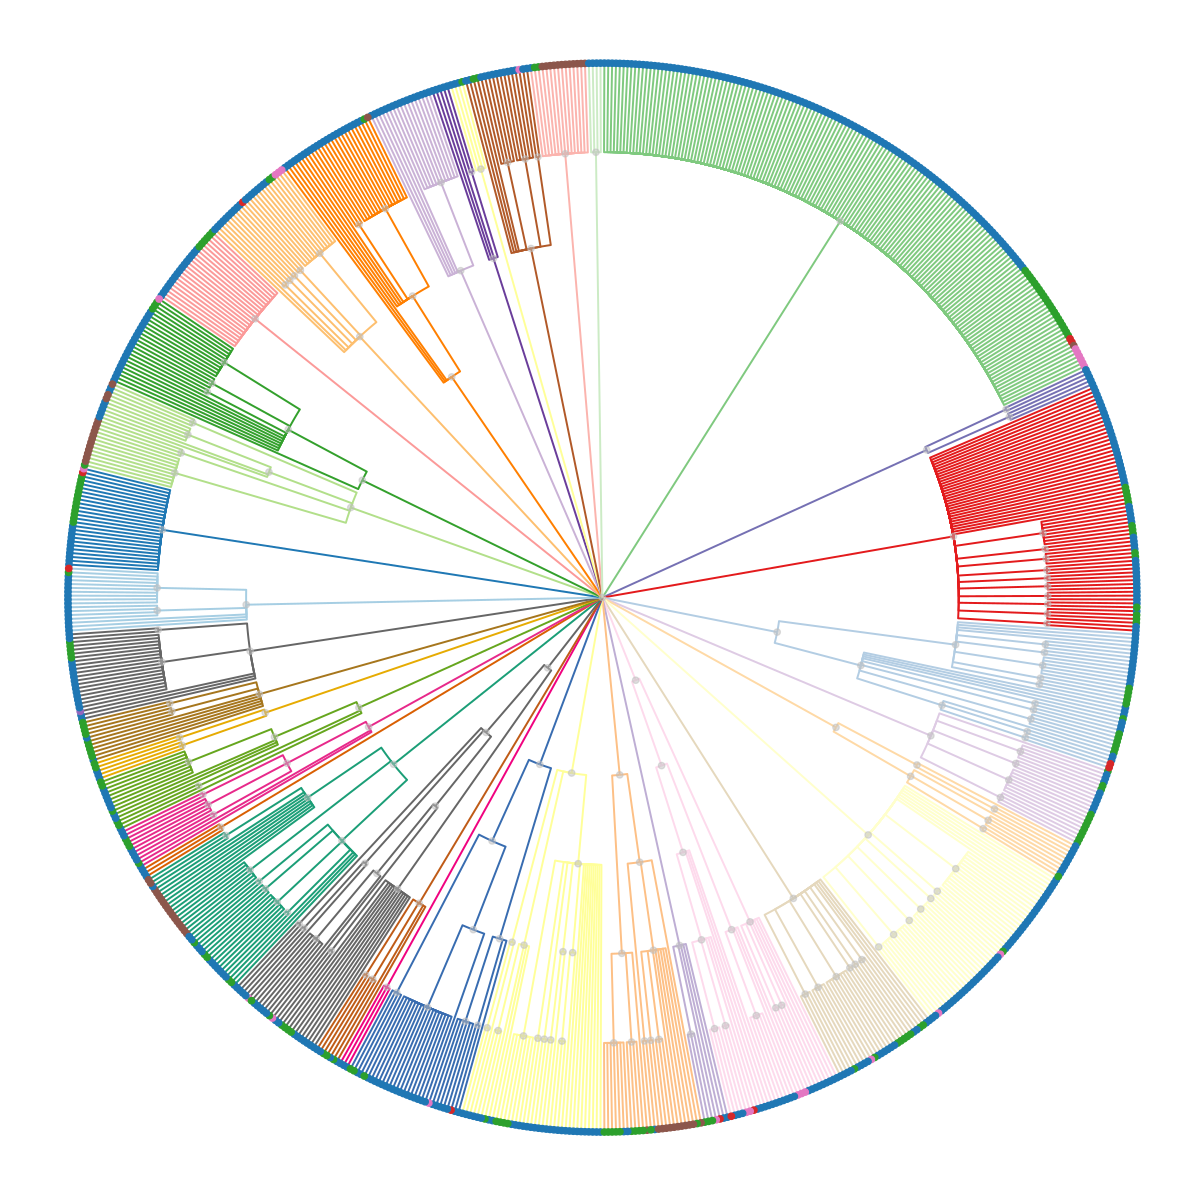

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 100)

master_elist_df2 = master_elist_df

### the below lines all deal with getting the clones to be plotted and colored in the correct order
master_elist_df2 = master_elist_df2 %>% mutate(clone = as.numeric(as.character(cloneID))) %>% arrange(clone)

master_elist_df2$cloneID = factor(master_elist_df2$cloneID, 
                                  levels = (unique(master_elist_df2$clone)))

master_elist_df2$cloneID = as.ordered(master_elist_df2$cloneID)

### start plotting portion
set.seed(1)

### make a vertices df which explicitly defines all nodes and provides metadata
### this is needed for igraph conversion below 
vertices = master_elist_df2 %>%
  arrange(cloneID) %>%
  distinct(V2, sample, cloneID) %>%
  add_row(V2 = 'root', sample = NA, cloneID = NA)

### convert to igraph
graph = graph_from_data_frame(master_elist_df2, vertices = vertices)

### plot
z <- ggraph(graph, layout = 'dendrogram', circular = TRUE) +
  geom_edge_elbow(aes(color = as.factor(cloneID))) + 
  scale_edge_color_manual(values = col_vector, guide = 'none') +
  scale_edge_width_continuous(range = c(.05, 2), breaks = c(10, 100, 1000, 5000), labels = c(10, 100, 1000, 5000),
                        name = 'Cells') +
  geom_node_point(aes(color = as.factor(sample), filter = leaf)) +
  geom_node_point(aes(filter=leaf==FALSE), size=1.5, color="grey", alpha=0.5) +
  scale_color_manual(values = cl_cols,
                     guide = 'none') +
  scale_size_continuous(range = c(0.1, 4), breaks = c(10, 100, 1000, 5000), labels = c(10, 100, 1000, 5000),
                        name = 'Cells') +
  coord_fixed() +
  theme(legend.key.width = unit(.3, 'in'))

plot(z)